In [2]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import time
import random
import h5py
import pandas as pd
from glob import glob
from os.path import join,basename
import keras
import tensorflow as tf
from tensorflow.python.ops import array_ops

In [3]:
def get_3_slice(x,y,ylabels,order): #y = seg, x = img
    X1=[]
    
    #print('shuffled order', order)
    for j in range(len(order)):
        tempx=x[:,:,order[j]-1:order[j]+2]
        #tempx=np.swapaxes(tempx,0,2)
        #tempy=np.swapaxes(tempy,0,2)
        
        X1.append(tempx) #.reshape([160,160,5])
    X1 = np.asarray(X1)
    print('shape&len',X1[0].shape,len(X1))
    return X1
    #X1, Y1, effective_slice,order=data_gen(b,a,testlabel)



In [4]:
def get_labels(lab):
    Y_labels = np.zeros([240,240,155,5])
    labels = [0,1,2,4,5]
    for l in range(0,5):
        Y_labels[:, :, :, l] = np.where(lab == labels[l], 1, 0)
    return Y_labels

In [5]:
def shuffle_order(flair_x,flair_y,ylabels,slice_no=155): #use flair as input
    order=[] 
    Y1 = []
    for i in range(slice_no):
        if (flair_x[:,:,i].any()!=0 and flair_y[:,:,i].any()!=0):
            if(i != 0 and i <152):
                order.append(i)
    #print('order',order)
    print('order len', len(order))
    random.shuffle(order)
    for j in range(len(order)):
        tempy=ylabels[:,:,order[j],:]
        Y1.append(tempy)
    Y1 = np.asarray(Y1)
    print('shape&len',Y1[0].shape,len(Y1))
    effective_slice=len(Y1) 
    return order, Y1, effective_slice 

In [6]:
def load_data(file):
    img = nib.load(file).get_data()
    seg =nib.load(file.replace('flair_corrected_normalized','new_seg')).get_data()
    Y_labels = get_labels(seg)
    order, Y1, effective_slice = shuffle_order(img,seg,Y_labels)
    img_t1ce = nib.load(file.replace('flair','t1ce')).get_data()
    img_t2 = nib.load(file.replace('flair','t2')).get_data()
    X1_t1ce = get_3_slice(img_t1ce,seg,Y_labels,order)
    X1_t2 = get_3_slice(img_t2,seg,Y_labels,order)
    X1_flair = get_3_slice(img,seg,Y_labels,order)
    X1 = [np.dstack((X1_t1ce[i],X1_t2[i],X1_flair[i])) for i in range(len(X1_t1ce))]
    print(X1[1].shape)
    print(len(X1))
    return np.asarray(X1), np.asarray(Y1), Y_labels,order

In [11]:
import sys 
sys.path.append(r'C:\Users\kejuan.li\Documents\git\Attention_UNet')
import AttSEResUNet
from keras.models import load_model
from AttSEResUNet import attention_block, double_conv_layer, gating_signal,expend_as,SE_block
model = AttSEResUNet.Attention_ResUNet_PA()

W0723 12:12:04.141652 10840 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:

#model=load_model('0722_acc.hdf5',  custom_objects={'SE_block':SE_block,'expend_as':expend_as,'gating_signal':gating_signal,'double_conv_layer':double_conv_layer,'attentin_block': attention_block,'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
#model.load_weights('0722_weights.h5')
#model.summary()

In [12]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
    """
   Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [13]:


def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.

        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.

    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def focal_acc(y_true, y_pred):
    return 1-focal_loss(y_true, y_pred)

In [14]:

def train_model(file,dc_array,loss_array,valloss_array,valdc_array,i):

    print('loading model structure')
    model = AttSEResUNet.Attention_ResUNet_PA()
    #model=keras.models.load_model('0722_acc.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

    #opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam',
                 loss =focal_loss, 
                 metrics = [focal_acc])
    if i:
        print('load_weight')
        model.load_weights('0722_weights_' +str(i-1) +'.h5')
    historry=model.fit(X1,Y1,validation_split=0.20, epochs=30, batch_size=10, verbose=1) #,callbacks=[metrics],callbacks=callbacks_list
    
    #model.save('0722_acc.hdf5')
    weight_name = '0722_weights_' +str(i) +'.h5'
    model.save_weights(weight_name)
    print('weight saved')


    #print(historry.history.keys())
    #print('loss', historry.history['loss'])
    #print('var_loss', historry.history['val_loss'])
    #print('val_dice_coef', historry.history['val_dice_coef'])
    #print('dice_coef', historry.history['dice_coef'])

    dc_array.append(historry.history['loss'])
    loss_array.append(historry.history['focal_acc'])
    valloss_array.append(historry.history['val_loss'])
    valdc_array.append(historry.history['val_focal_acc'])
    return

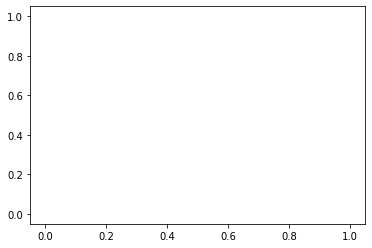

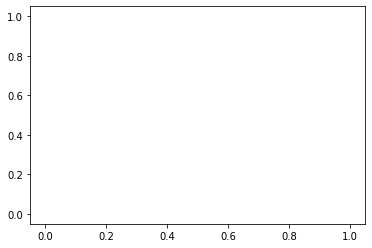

In [28]:
dc = np.asarray(dc_array)
plt.plot(dc.flatten())
plt.show()
valdc = np.asarray(valdc_array)
plt.plot(valdc.flatten())
plt.show()

In [80]:
#get right order
def reorder_seg(pred0,order_test):
    reorg_seg=np.zeros([155,240,240,5])
    print(len(order_test))
    for i in range(len(order_test)):
        reorg_seg[order_test[i],:,:,:]=pred0[i,:,:,:]

#print(reorg_seg.shape)
    return reorg_seg

#decode onehot
def onehot_decode(pred0, img_shape=[155,240,240]):
    decoded_pred=np.zeros(img_shape)
    #pred = np.around(pred0)
    pred=pred0.argmax(axis=-1)[...,None]==np.arange(pred0.shape[-1])
    pred=pred+0
    #print(pred.shape)
    for l in range(5):
        decoded_pred+=l*pred[:,:,:,l]
    decoded_pred = np.where(decoded_pred==4.0,5,decoded_pred)
    decoded_pred = np.where(decoded_pred==3.0,4,decoded_pred)

    return decoded_pred


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
config = tf.configProto()

In [17]:
#load test data
dir_name = r'Z:\BraTS2019Data\MICCAI_BraTS_2019_Data_Training' 
file_list_1 = glob(join(dir_name,'*','*','*_flair_corrected_normalized.nii.gz'))



In [66]:
print(isinstance(decoded_pred[0,0,0],int))

False


In [ ]:
model_2_test = AttSEResUNet.Attention_ResUNet_PA()
model_2_test.compile(optimizer='adam',
                 loss =focal_loss, 
                 metrics = [focal_acc])

In [235]:
t = 77
model_2_test.load_weights(r'Z:\workspace\0722_weights_' +str(t) +'.h5')
#model_2_test.load_weights(r'Z:\workspace\weights_file\0722_weights_' +str(t) +'.h5')

In [236]:
i=130
print(file_list_1[i])
X1_test, Y1_test, Y_labels_test,order_test = load_data(file_list_1[i])
mask =nib.load(file_list_1[i].replace('flair_corrected_normalized','new_seg')).get_data()
pred0 = model_2_test.predict(X1_test, batch_size = 15) 

Z:\BraTS2019Data\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_CBICA_AUW_1\BraTS19_CBICA_AUW_1_flair_corrected_normalized.nii.gz
order len 134
shape&len (240, 240, 5) 134
shape&len (240, 240, 3) 134
shape&len (240, 240, 3) 134
shape&len (240, 240, 3) 134
(240, 240, 9)
134


In [237]:
reorg_seg=reorder_seg(pred0,order_test)
decoded_pred=onehot_decode(reorg_seg)

134


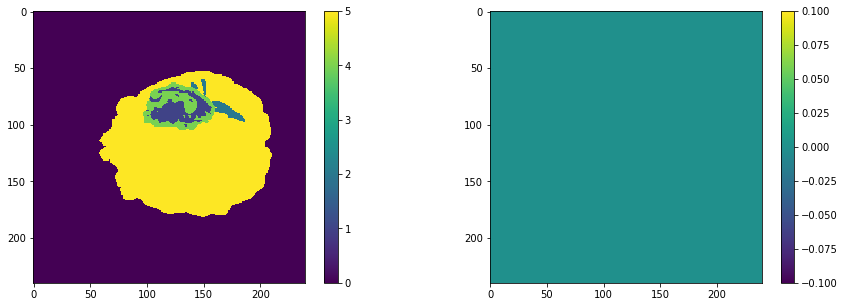

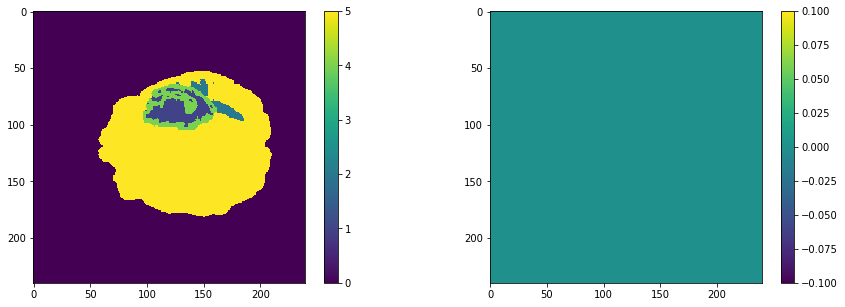

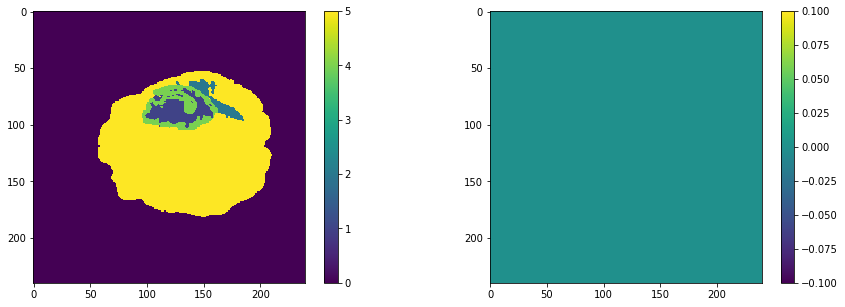

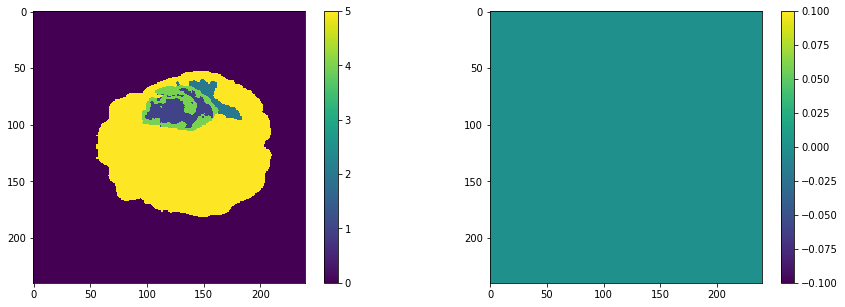

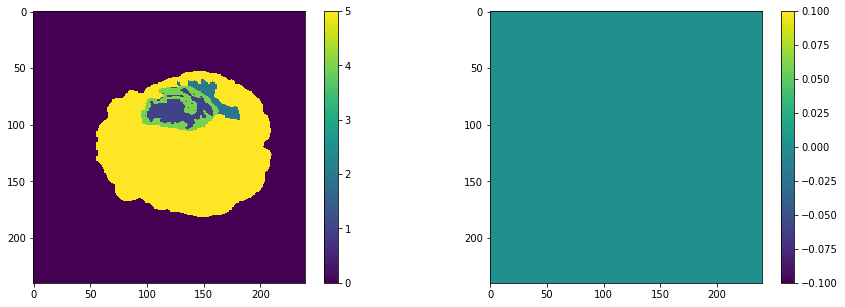

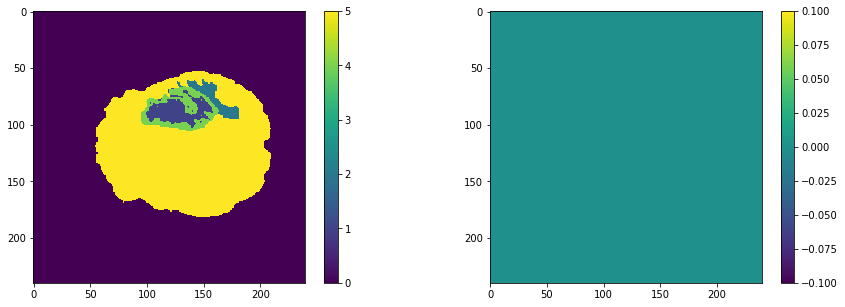

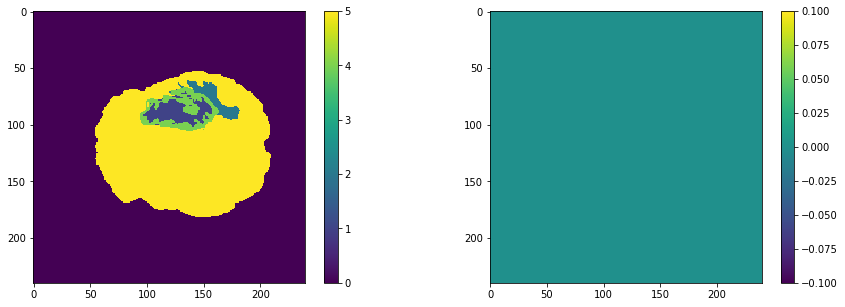

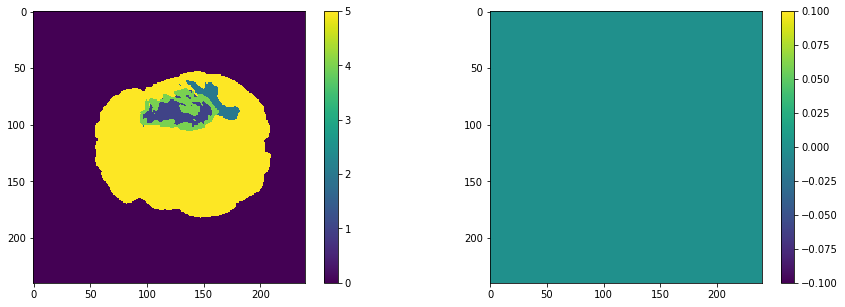

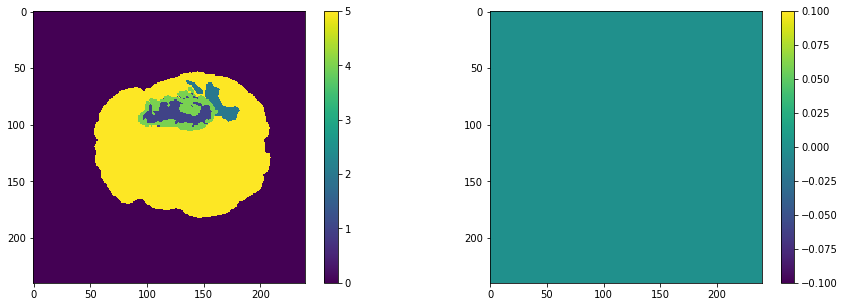

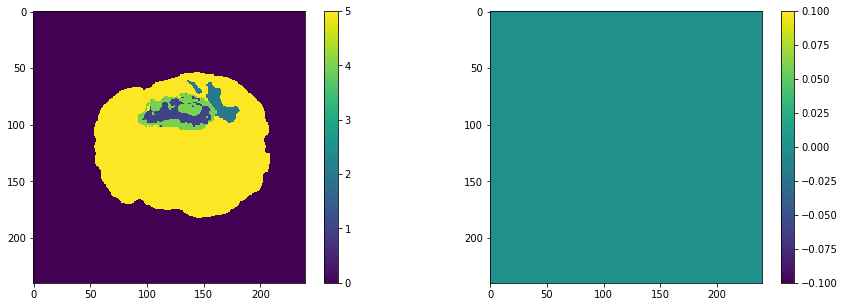

In [238]:
import matplotlib.pyplot as plt
%matplotlib inline
for k in (range(70,80)):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.imshow(mask[:,:,k])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(decoded_pred[k,:,:])
    plt.colorbar()
    plt.show()

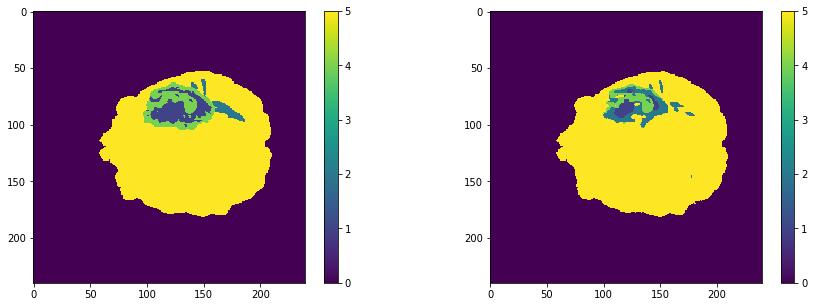

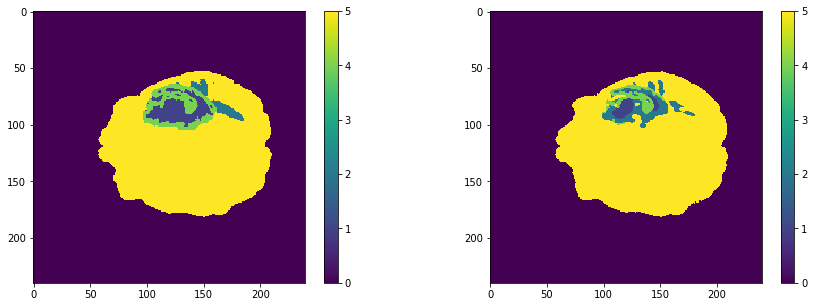

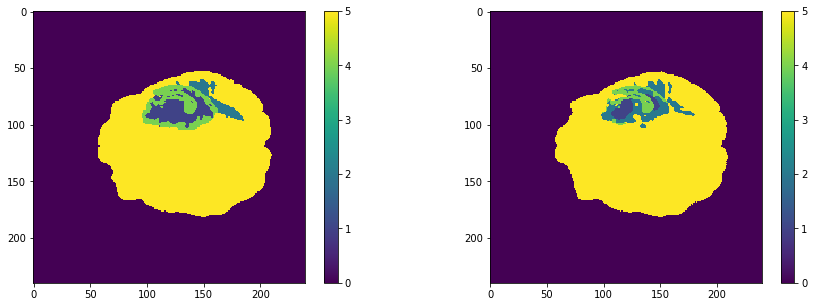

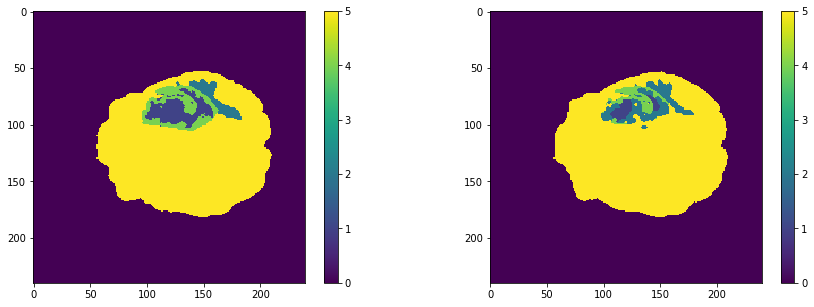

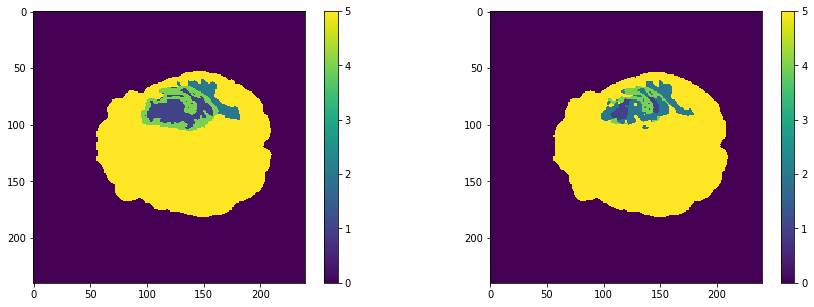

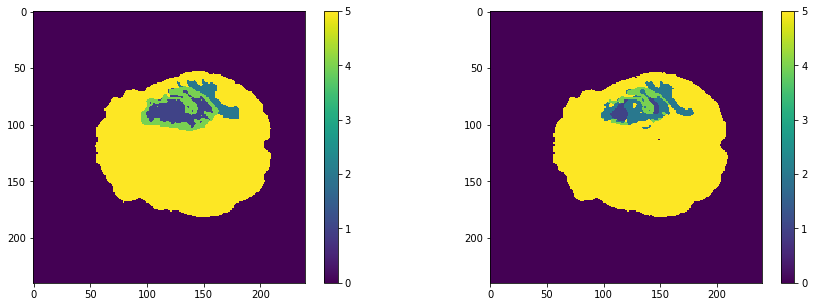

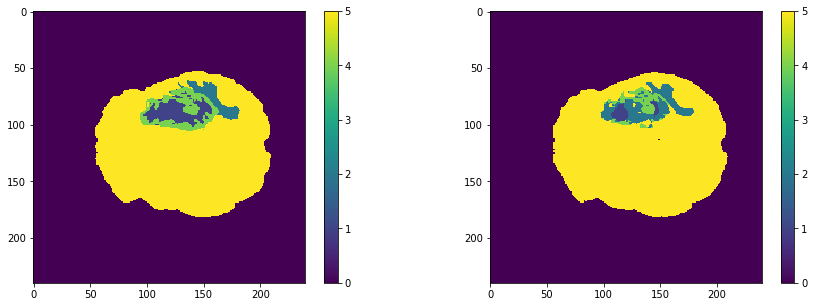

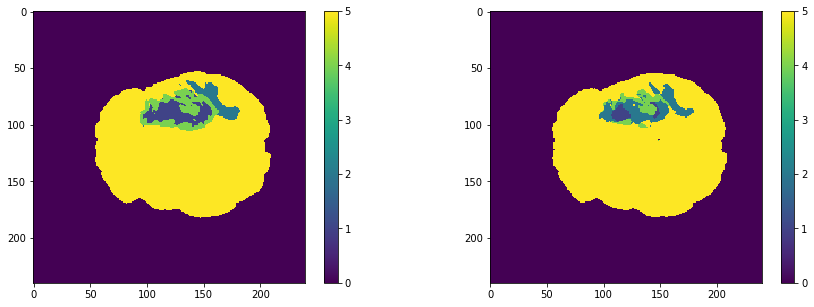

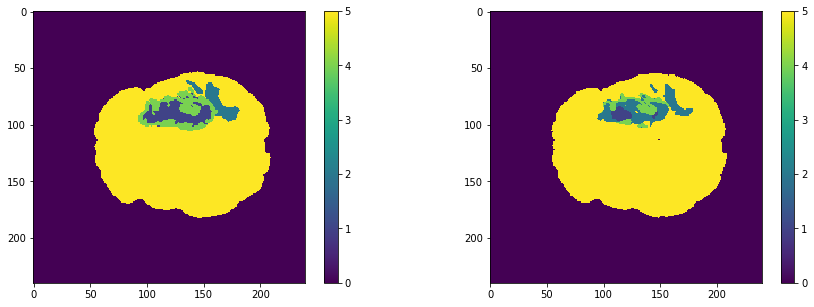

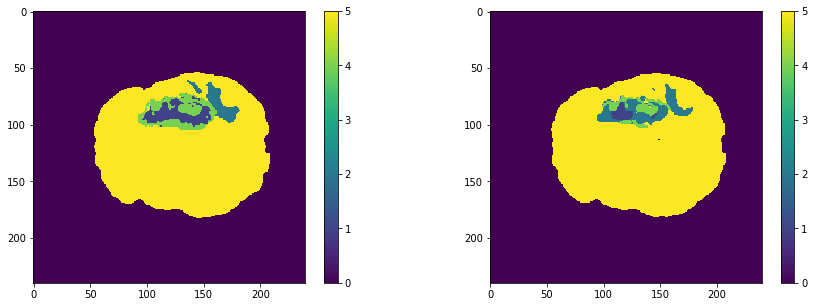

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline
for k in (range(70,80)):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.imshow(mask[:,:,k])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(decoded_pred[k,:,:])
    plt.colorbar()
    plt.show()

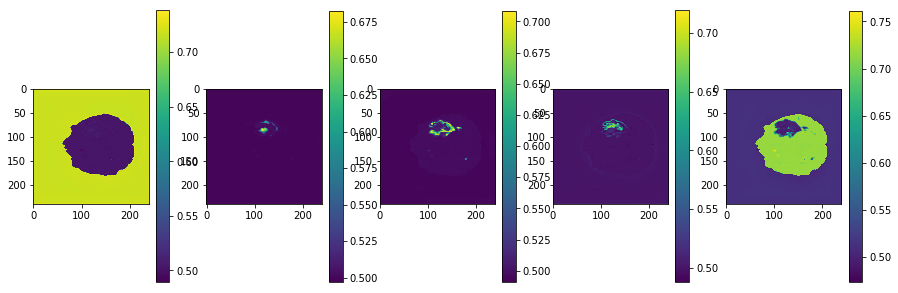

In [234]:
s = 50
plt.figure(figsize = (15,5))
plt.subplot(1,5,1)
plt.imshow(pred0[s,:,:,0])
plt.colorbar()
plt.subplot(1,5,2)
plt.imshow(pred0[s,:,:,1])
plt.colorbar()
plt.subplot(1,5,3)
plt.imshow(pred0[s,:,:,2])
plt.colorbar()
plt.subplot(1,5,4)
plt.imshow(pred0[s,:,:,3])
plt.colorbar()
plt.subplot(1,5,5)
plt.imshow(pred0[s,:,:,4])
plt.colorbar()
plt.show()

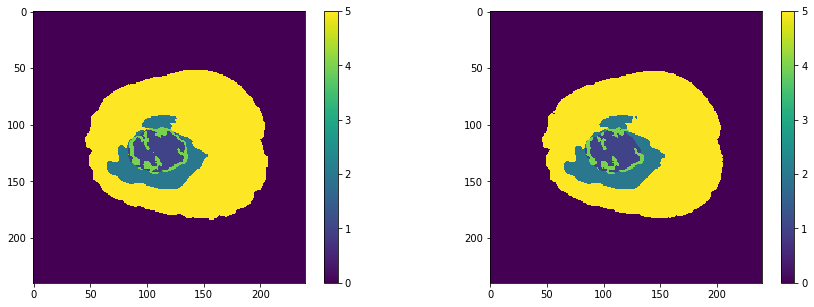

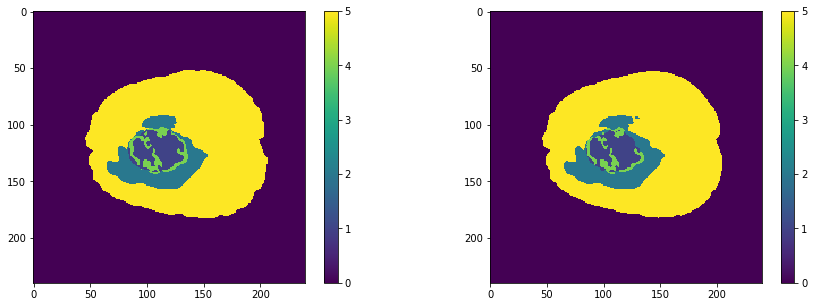

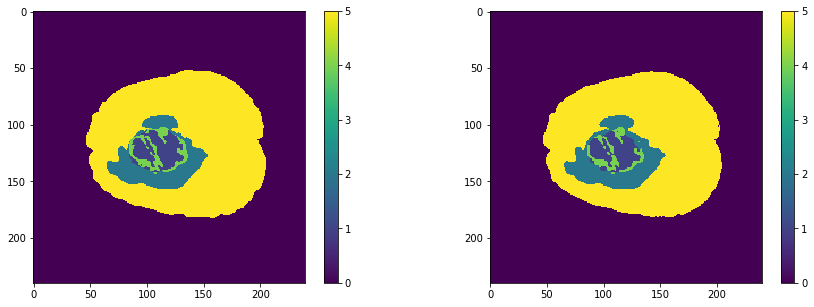

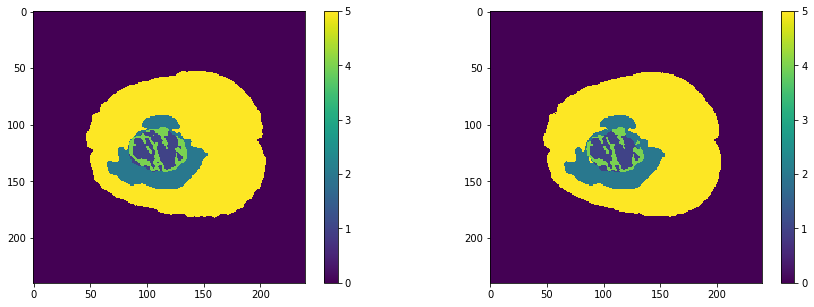

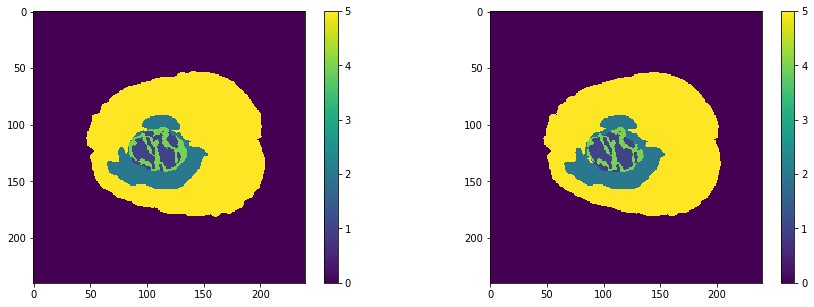

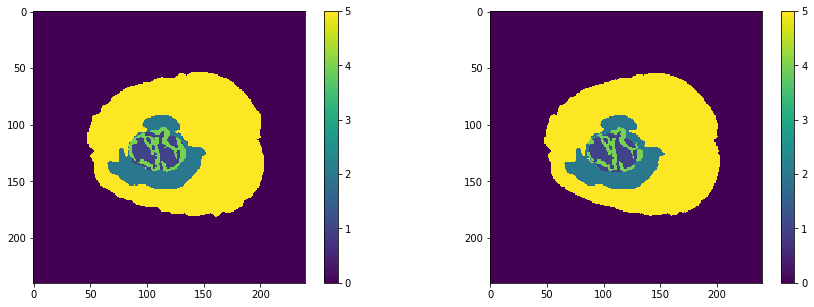

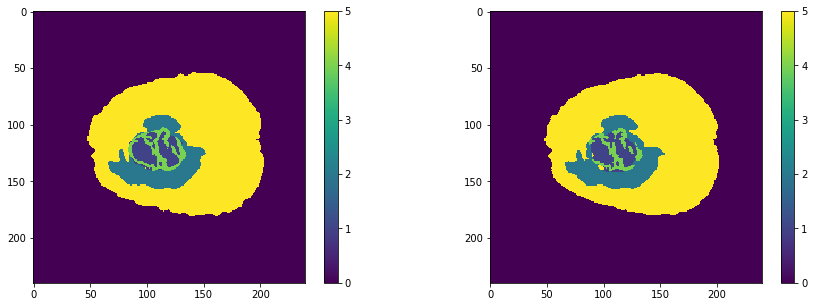

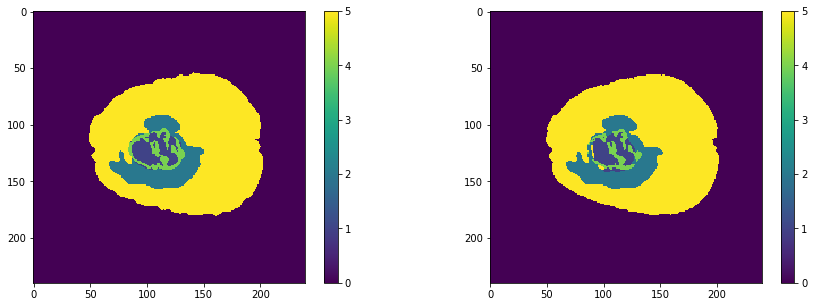

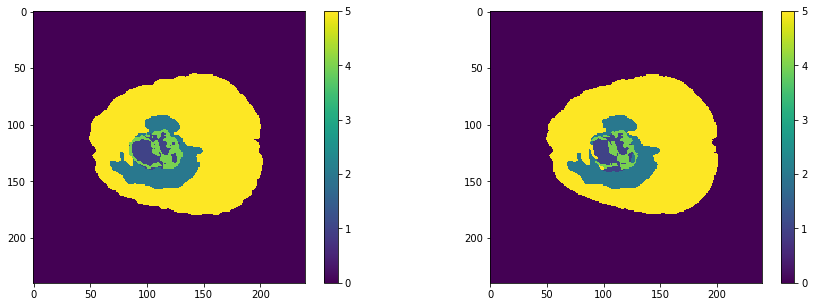

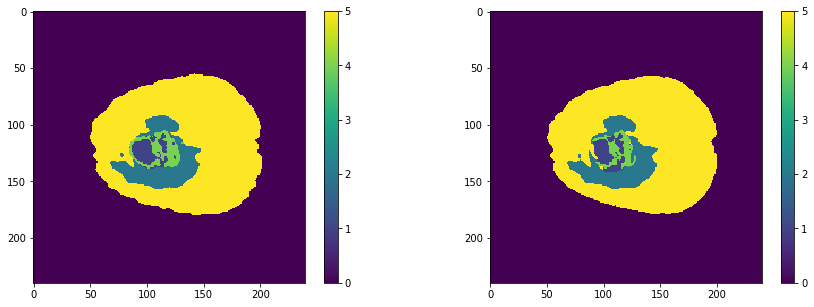

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
for k in (range(100,110)):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.imshow(mask[:,:,k])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(decoded_pred[k,:,:])
    plt.colorbar()
    plt.show()
    #print('\n')